# NFL QB Exploratory Data Analysis

I'm exploring the QB statistics data to understand what metrics matter most and identify any patterns that could help my custom rating system. This analysis can hopefully help me decide which features to use for the 6 dimensions: Mobility, Aggression, Accuracy, Ball Security, Pocket Presence, and Playmaking.

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

sns.set(style="whitegrid")

In [7]:
# Load QB statistics from the database
db_path = '../nfl_qb_data.db'
conn = sqlite3.connect(db_path)

df = pd.read_sql('SELECT * FROM qb_statistics', conn)

print(f"Loaded {len(df)} rows from qb_statistics")
df.head()

Loaded 10029 rows from qb_statistics


,player_id,player_name,position,position_group,headshot_url,season,week,season_type,team,opponent_team,...,rushing_first_downs,rushing_epa,rushing_2pt_conversions,total_epa,td_int_ratio,completion_pct,yards_per_attempt,dropbacks,turnover_pct,negative_play_pct
0,00-0004161,Jake Delhomme,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,CLE,TB,...,0,-1.174043,0,-9.903052,4.999998e-01,0.540541,6.135135,37,5.405405,5.405405
1,00-0005106,Brett Favre,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,MIN,NO,...,0,NaN,0,-4.680712,9.999990e-01,0.555556,6.333333,28,3.571429,7.142857
2,00-0007091,Matt Hasselbeck,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,SEA,SF,...,1,0.632133,0,6.659551,1.999998e+00,0.782609,7.391304,24,4.166667,8.333333
3,00-0010346,Peyton Manning,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,IND,HOU,...,0,NaN,0,18.796529,3.000000e+06,0.701754,7.596491,59,0.000000,3.389831
4,00-0011022,Donovan McNabb,QB,QB,https://static.www.nfl.com/image/private/f_aut...,2010,1,REG,WAS,DAL,...,1,2.184220,0,-2.838038,0.000000e+00,0.468750,5.343750,33,0.000000,3.030303


## EPA Distribution

EPA (Expected Points Added) is one of the most important metrics for evaluating QB performance. I want to see if it follows a normal distribution and check for any extreme outliers.

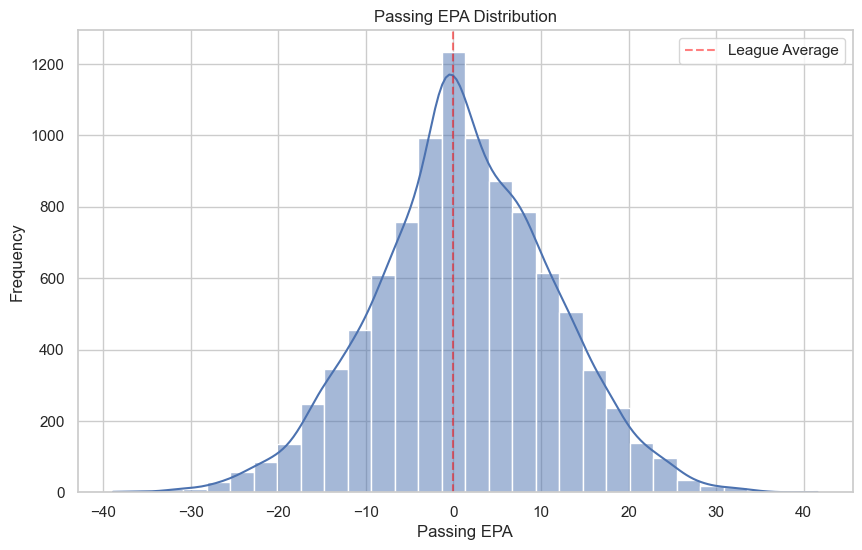

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['passing_epa'].dropna(), bins=30, kde=True)
plt.title('Passing EPA Distribution')
plt.xlabel('Passing EPA')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', alpha=0.5, label='League Average')
plt.legend()
plt.show()

## Key Metrics Overview

I'm checking the distributions and correlations of the key stats that will feed into my rating dimensions. This helps me understand which metrics are related and which capture unique aspects of QB play.

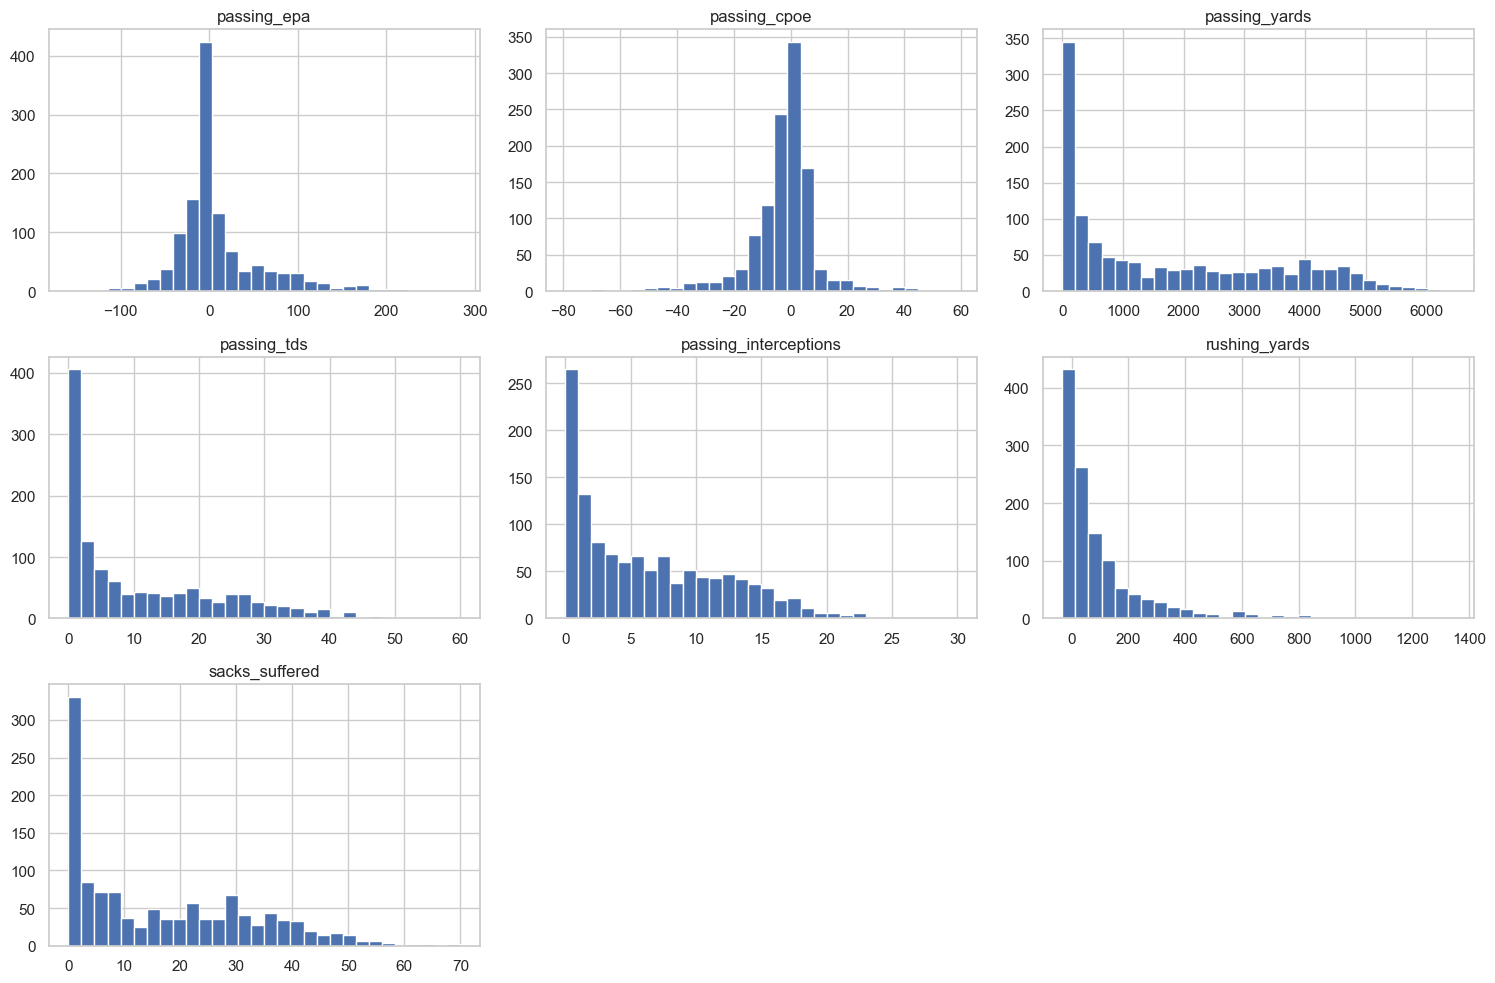

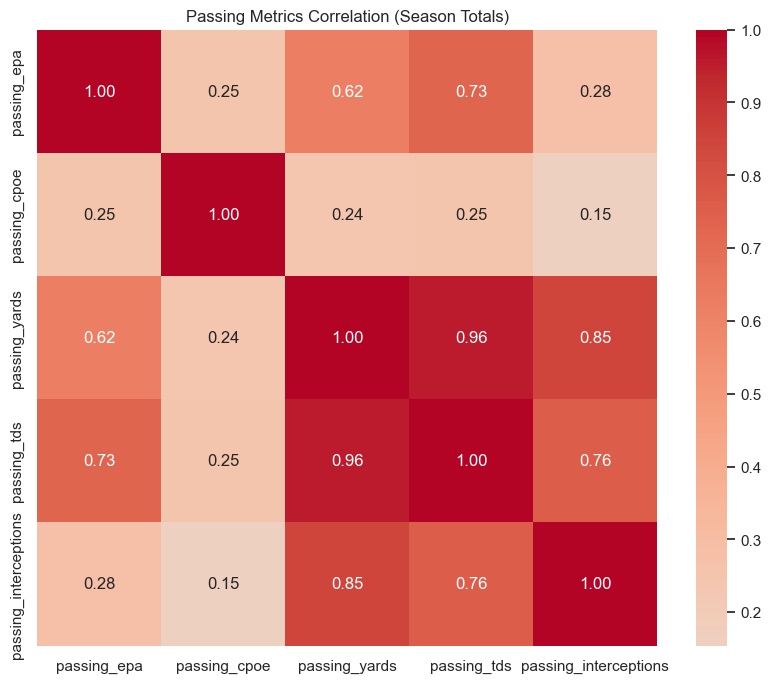

In [9]:
# Aggregate weekly stats to season totals for better visualization
season_stats = df.groupby(['player_id', 'player_name', 'season']).agg({
    'passing_epa': 'sum',
    'passing_cpoe': 'mean',
    'passing_yards': 'sum',
    'passing_tds': 'sum',
    'passing_interceptions': 'sum',
    'rushing_yards': 'sum',
    'sacks_suffered': 'sum'
}).reset_index()

# Check distributions for key season-level stats
key_features = ['passing_epa', 'passing_cpoe', 'passing_yards', 'passing_tds', 
                'passing_interceptions', 'rushing_yards', 'sacks_suffered']

season_stats[key_features].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.tight_layout()
plt.show()

# See how passing metrics correlate at the season level
passing_metrics = ['passing_epa', 'passing_cpoe', 'passing_yards', 'passing_tds', 'passing_interceptions']
plt.figure(figsize=(10, 8))
sns.heatmap(season_stats[passing_metrics].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Passing Metrics Correlation (Season Totals)')
plt.show()

A few things I noticed from the histograms is that a couple of the fields have quite a lot of zeros that will likely need to be removed later on for modeling. In the correlation matrix, I see that CPOE (Accuracy metric) is not highly correlated with the other "volume" stats. I also see that passing yards are strongly correlated with interceptions, meaning players that can avoid interceptions while throwing for a lot of yards are rare.

## Performance Trends by Season

I want to see if QB play has changed over time. Are QBs getting better at avoiding sacks? Is EPA per attempt trending upward? This context matters for normalizing ratings across different eras.

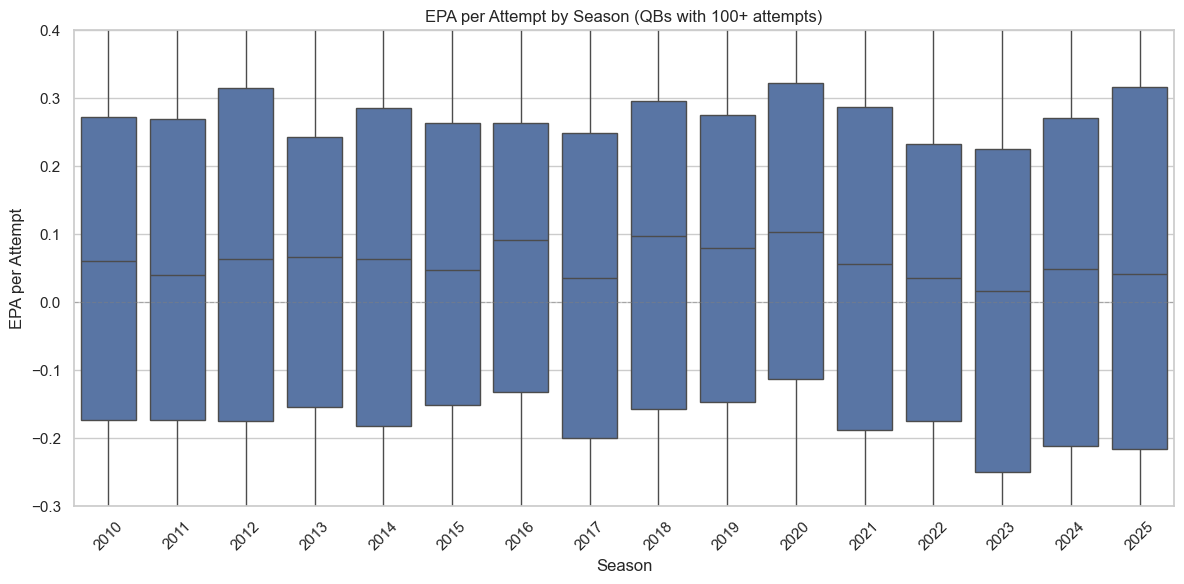

Filtered from 10029 total games to 8584 games from qualified QBs


In [10]:
# Calculate EPA per attempt for better comparison across QBs with different volume
attempt_col = 'attempts' if 'attempts' in df.columns else 'passing_attempts'
df['epa_per_attempt'] = df['passing_epa'] / df[attempt_col].replace(0, np.nan)

# Filter to QBs with meaningful sample size (100+ attempts per season)
season_attempts = df.groupby(['player_id', 'season'])[attempt_col].sum()
qualified_qbs = season_attempts[season_attempts >= 100].index
df_qualified = df.set_index(['player_id', 'season']).loc[qualified_qbs].reset_index()

# Visualize how EPA per attempt has changed by season for qualified QBs
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='epa_per_attempt', data=df_qualified)
plt.title('EPA per Attempt by Season (QBs with 100+ attempts)')
plt.ylabel('EPA per Attempt')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.5)
plt.ylim(-0.3, 0.4)
plt.tight_layout()
plt.show()

print(f"Filtered from {len(df)} total games to {len(df_qualified)} games from qualified QBs")

Filtered to QB's with 100+ attempts so we could get a clearer picture. I was trying to see if EPA increased over the last 15 seasons or not, and there does not seem to be a clear trend of that. If anything, the EPA floor seems lower in the last few years.

## Missing Data Check

I need to see which fields have missing values. Some missing data is expected (e.g., not every QB has rushing stats), but I want to make sure critical metrics like EPA and CPOE are mostly complete.

In [12]:
# Check missing data patterns
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

# Filter to only columns with missing data and sort by count
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(f"Total rows in dataset: {len(df)}\n")
print("Columns with missing data:")
print(missing_data.to_string(index=False))

Total rows in dataset: 10029

Columns with missing data:
         Column  Missing_Count  Missing_Percentage
    rushing_epa           1574               15.69
   passing_cpoe            442                4.41
           pacr            440                4.39
epa_per_attempt            433                4.32
    passing_epa            406                4.05


The missing data is pretty minimal overall (under 16% for all fields). The biggest issue is Rushing EPA at 15.69%, but that makes sense - not all QBs rush frequently, and some games they don't rush at all. The advanced metrics like Passing EPA and CPOE are only missing in about 4% of games, which is good since these are critical for my rating system. These missing values likely come from games where QBs had very few snaps (backups coming in for injured starters, etc.). I'll need to handle these during modeling, probably by filtering out games with too few attempts or filling with zeros where appropriate.

## Feature Engineering

I'm creating derived metrics that will be useful for my rating system. These include rate stats (completion %, yards per attempt), efficiency metrics (TD/INT ratio), and turnover rates that capture ball security.

In [ ]:
# Create useful derived metrics
df['total_epa'] = df['passing_epa'].fillna(0) + df['rushing_epa'].fillna(0)

# TD/INT ratio (add small value to avoid division by zero)
df['td_int_ratio'] = df['passing_tds'] / (df['passing_interceptions'] + 0.01)

# Completion percentage
df['completion_pct'] = np.where(df['attempts'] > 0, 
                                 df['completions'] / df['attempts'] * 100, 
                                 np.nan)

# Yards per attempt
df['yards_per_attempt'] = np.where(df['attempts'] > 0, 
                                     df['passing_yards'] / df['attempts'], 
                                     np.nan)

# Total dropbacks (attempts + sacks)
df['dropbacks'] = df['attempts'].fillna(0) + df['sacks_suffered'].fillna(0)
safe_dropbacks = df['dropbacks'].replace(0, np.nan)

# Turnover rate (fumbles lost + interceptions per dropback)
sack_fumbles = df['sack_fumbles_lost'].fillna(0)
rush_fumbles = df['rushing_fumbles_lost'].fillna(0)
ints = df['passing_interceptions'].fillna(0)

df['turnover_rate'] = ((sack_fumbles + rush_fumbles + ints) / safe_dropbacks) * 100

# Sack rate (important for pocket presence rating)
df['sack_rate'] = (df['sacks_suffered'].fillna(0) / safe_dropbacks) * 100

print("Created features:")
print("- total_epa: Combined passing + rushing EPA")
print("- td_int_ratio: Touchdown to interception ratio")
print("- completion_pct: Completion percentage")
print("- yards_per_attempt: Average yards per pass attempt")
print("- turnover_rate: Fumbles + INTs per dropback")
print("- sack_rate: Sacks per dropback")

print("\n\nTurnover Rate Summary:")
print(df['turnover_rate'].describe())
print("\n\nSack Rate Summary:")
print(df['sack_rate'].describe())

New features created (NaN-safe):
- total_epa, td_int_ratio, completion_pct, yards_per_attempt
- turnover_pct (fumbles lost + INTs per dropback)
- negative_play_pct (sacks + fumbles lost + INTs per dropback)

Turnover % stats (after cleaning):
count    10029.000000
mean         2.968187
std          5.543285
min          0.000000
25%          0.000000
50%          2.272727
75%          4.347826
max        100.000000
Name: turnover_pct, dtype: float64

Negative play % stats (after cleaning):
count    10029.000000
mean         9.448995
std          9.818151
min          0.000000
25%          3.703704
50%          8.108108
75%         12.500000
max        200.000000
Name: negative_play_pct, dtype: float64


I noticed that turnover % is 100% for the max, which means that a player turned it over on their only play potentially. Those types of outliers could throw off calculations down the line so I'll have to be aware of that. Same with negative play% having a max of 200%, likely a datapoint that was calculated incorrectly or mis-entered.

In [ ]:
# Save enriched dataset with new features
with sqlite3.connect(db_path) as _conn:
    df.to_sql('qb_statistics_enriched', _conn, if_exists='replace', index=False)

print(f"Saved enriched dataset to qb_statistics_enriched table")
print(f"Total columns: {len(df.columns)}")
print(f"Added {len(df.columns) - len(pd.read_sql('SELECT * FROM qb_statistics LIMIT 1', conn).columns)} new features")

Saved enriched QB dataset to table: qb_statistics_enriched
Columns saved: 41


Adds new features into my sqlite database table

## Testing Modified Rating Formula

Testing new weights: Efficiency 30% (was 40%), Pressure 10% (was 5%), Volume 10% (was 7.5%), Consistency 22.5% (was 20%).

In [ ]:
db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'
conn = sqlite3.connect(db_path)

test_df = pd.read_sql_query("SELECT * FROM qb_season_stats WHERE season = 2025", conn)

conn.close()

def normalize_feature(series, invert=False):
    min_val = series.min()
    max_val = series.max()
    
    if max_val > min_val:
        normalized = (series - min_val) / (max_val - min_val)
        normalized = 50 + (normalized * 50)
        if invert:
            normalized = 150 - normalized
        return normalized
    else:
        return pd.Series([75] * len(series), index=series.index)

test_df['total_pass_epa_norm'] = normalize_feature(test_df['total_pass_epa'])
test_df['pass_success_rate_norm'] = normalize_feature(test_df['pass_success_rate'])
test_df['cpoe_norm'] = normalize_feature(test_df['cpoe'])
test_df['total_wpa_norm'] = normalize_feature(test_df['total_wpa'])
test_df['high_leverage_epa_norm'] = normalize_feature(test_df['high_leverage_epa'])
test_df['td_rate_norm'] = normalize_feature(test_df['td_rate'])
test_df['third_down_success_norm'] = normalize_feature(test_df['third_down_success'])
test_df['red_zone_epa_norm'] = normalize_feature(test_df['red_zone_epa'])
test_df['completion_pct_norm'] = normalize_feature(test_df['completion_pct'])
test_df['pass_yards_per_game_norm'] = normalize_feature(test_df['pass_yards_per_game'])
test_df['rush_yards_per_game_norm'] = normalize_feature(test_df['rush_yards_per_game'])
test_df['total_tds_per_game_norm'] = normalize_feature(test_df['total_tds_per_game'])
test_df['turnover_rate_norm'] = normalize_feature(test_df['turnover_rate'], invert=True)
test_df['sack_rate_norm'] = normalize_feature(test_df['sack_rate'], invert=True)
test_df['epa_under_pressure_norm'] = normalize_feature(test_df['epa_under_pressure'])

efficiency_score = (
    0.50 * test_df['total_pass_epa_norm'] +
    0.30 * test_df['pass_success_rate_norm'] +
    0.20 * test_df['cpoe_norm']
)

impact_score = (
    0.50 * test_df['total_wpa_norm'] +
    0.30 * test_df['high_leverage_epa_norm'] +
    0.20 * test_df['td_rate_norm']
)

consistency_score = (
    0.40 * test_df['third_down_success_norm'] +
    0.35 * test_df['red_zone_epa_norm'] +
    0.25 * test_df['completion_pct_norm']
)

volume_score = (
    0.40 * test_df['pass_yards_per_game_norm'] +
    0.40 * test_df['rush_yards_per_game_norm'] +
    0.20 * test_df['total_tds_per_game_norm']
)

ball_security_score = (
    0.40 * test_df['turnover_rate_norm'] +
    0.60 * test_df['sack_rate_norm']
)

pressure_score = test_df['epa_under_pressure_norm']

test_df['modified_rating'] = (
    0.30 * efficiency_score +
    0.175 * impact_score +
    0.225 * consistency_score +
    0.10 * volume_score +
    0.10 * ball_security_score +
    0.10 * pressure_score
).clip(50, 100)

results = test_df[['player_name', 'modified_rating', 'total_pass_epa', 'pass_success_rate', 'epa_under_pressure']].sort_values('modified_rating', ascending=False)

print("2025 QB Rankings with Modified Formula")
print("="*80)
print(f"Weights: Efficiency 30%, Impact 17.5%, Consistency 22.5%, Volume 10%, Ball Security 10%, Pressure 10%\n")
print(results.head(20).to_string(index=False))